Research Paper: https://arxiv.org/abs/1503.02531

This is the foundational paper that introduced the idea of knowledge distillation

Dataset: MNIST


Code Link:
1. https://github.com/tripdancer0916/keras-knowledge-distillation/tree/master
1. https://github.com/poperson1205/knowledge_distillation

Training the student not only to predict the correct labels but also to mimic the soft probabilities of the teacher. These soft probabilities, often computed with a high temperature in the softmax, carry richer information than one-hot hard labels.

In [ ]:
# import libaraies
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [ ]:
# CIFAR10 - Data Preparation
# the paper used MNST
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:

# define the Teacher and Student models
teacher = torchvision.models.resnet34(pretrained=True).cuda()
student = torchvision.models.resnet18(pretrained=False).cuda()

# define the loss function and optimizers
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(student.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 316MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

In [ ]:
train_losses = []
train_accuracies = []
test_accuracies = []

def test_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return 100 * correct / total

# Training
epochs = 10
for epoch in range(epochs):
    student.train()
    teacher.eval()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.cuda(), targets.cuda()

        optimizer.zero_grad()

        student_outputs = student(inputs)
        teacher_outputs = teacher(inputs).detach()

        # KD loss
        loss = criterion(student_outputs, targets) + \
               nn.KLDivLoss()(F.log_softmax(student_outputs, dim=1),
                              F.softmax(teacher_outputs, dim=1))

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = student_outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_loss = total_loss / (batch_idx + 1)
    train_acc = 100. * correct / total

    test_acc = test_accuracy(student, testloader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    print(f"Epoch {epoch+1}/{epochs}.. Train Loss: {train_loss:.4f}.. Train Accuracy: {train_acc:.2f}.. Test Accuracy: {test_acc:.2f}")

    scheduler.step()



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 1/10.. Train Loss: 2.1660.. Train Accuracy: 29.10.. Test Accuracy: 38.36
Epoch 2/10.. Train Loss: 1.5473.. Train Accuracy: 43.87.. Test Accuracy: 47.84
Epoch 3/10.. Train Loss: 1.3461.. Train Accuracy: 51.71.. Test Accuracy: 52.83
Epoch 4/10.. Train Loss: 1.1815.. Train Accuracy: 58.11.. Test Accuracy: 59.06
Epoch 5/10.. Train Loss: 1.0808.. Train Accuracy: 62.57.. Test Accuracy: 60.02
Epoch 6/10.. Train Loss: 1.0108.. Train Accuracy: 64.95.. Test Accuracy: 63.75
Epoch 7/10.. Train Loss: 0.9543.. Train Accuracy: 67.05.. Test Accuracy: 60.72
Epoch 8/10.. Train Loss: 0.9135.. Train Accuracy: 68.60.. Test Accuracy: 66.30
Epoch 9/10.. Train Loss: 0.8868.. Train Accuracy: 69.96.. Test Accuracy: 64.20
Epoch 10/10.. Train Loss: 0.8616.. Train Accuracy: 70.46.. Test Accuracy: 67.45


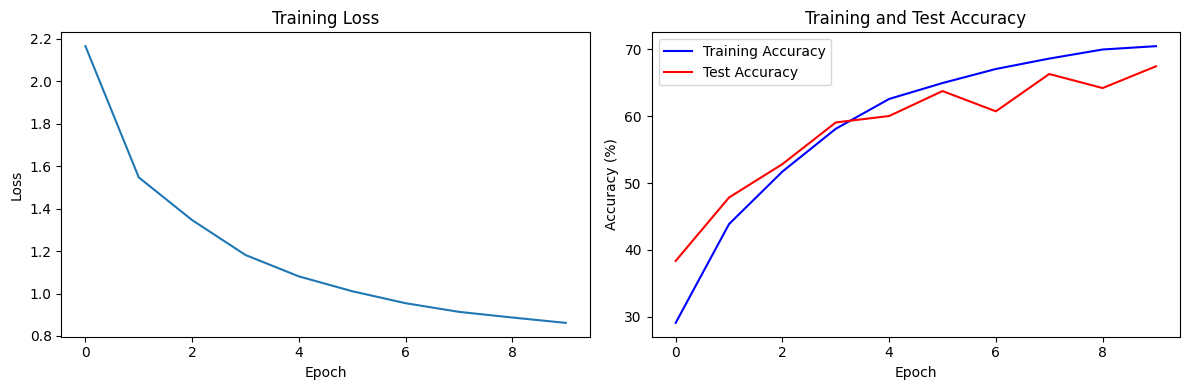

In [ ]:
# Plot the training loss and training/test accuracies
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(test_accuracies, label='Test Accuracy', color='red')
plt.title("Training and Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()


The temperature parameter T is crucial: Higher values of T produce softer probability distributions. Both the teacher and student must use the same T when producing their soft labels.

In [ ]:
# import libaraies
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [ ]:
# Load CIFAR-10 data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# the teacher model (CNN)
class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.fc1 = nn.Linear(128 * 6 * 6, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 128 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

teacher = Teacher()

In [ ]:
# the student model (smaller than the teacher)
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 15 * 15, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 32 * 15 * 15)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

student = Student()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_teacher = optim.Adam(teacher.parameters(), lr=0.001)
optimizer_student = optim.Adam(student.parameters(), lr=0.001)


teacher_train_losses = []
student_train_losses = []
test_accuracies = []

# train the teacher model
for epoch in range(20):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        optimizer_teacher.zero_grad()
        outputs = teacher(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_teacher.step()
        running_loss += loss.item()

    teacher_train_losses.append(running_loss / len(trainloader))
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")

print("Finished training the teacher\n")

# KD parameters
temperature = 5.0   # parameter T
soft_labels_criterion = nn.KLDivLoss(reduction="batchmean")


# KD
for epoch in range(20):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        optimizer_student.zero_grad()

        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            soft_labels = torch.nn.functional.softmax(teacher_outputs / temperature, dim=1)

        student_outputs = student(inputs)
        soft_predictions = torch.nn.functional.log_softmax(student_outputs / temperature, dim=1)

        loss_hard = criterion(student_outputs, labels)
        loss_soft = soft_labels_criterion(soft_predictions, soft_labels)

        loss = loss_hard + loss_soft
        loss.backward()
        optimizer_student.step()
        running_loss += loss.item()

    student_train_losses.append(running_loss / len(trainloader))
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")

    # Test the student model
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = student(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracies.append(100 * correct / total)

Epoch 1, Loss: 1.417507754567334
Epoch 2, Loss: 1.039069031053187
Epoch 3, Loss: 0.8820966960828932
Epoch 4, Loss: 0.7770481595907675
Epoch 5, Loss: 0.677732259187552
Epoch 6, Loss: 0.5970738325887324
Epoch 7, Loss: 0.5206863362618419
Epoch 8, Loss: 0.4490539077145364
Epoch 9, Loss: 0.3723859112052357
Epoch 10, Loss: 0.3105859251507103
Epoch 11, Loss: 0.25686405877323104
Epoch 12, Loss: 0.2100245684309079
Epoch 13, Loss: 0.1636163881405845
Epoch 14, Loss: 0.1330510650468452
Epoch 15, Loss: 0.11294481152539973
Epoch 16, Loss: 0.08734152744740933
Epoch 17, Loss: 0.07731948721477443
Epoch 18, Loss: 0.06961245057851914
Epoch 19, Loss: 0.07734210538151472
Epoch 20, Loss: 0.061966952622470345
Finished training the teacher

Epoch 1, Loss: 2.392480623081822
Epoch 2, Loss: 1.9705182972466548
Epoch 3, Loss: 1.7774369558105079
Epoch 4, Loss: 1.6357948719083195
Epoch 5, Loss: 1.5150029256825557
Epoch 6, Loss: 1.4100205962310361
Epoch 7, Loss: 1.3193285802136296
Epoch 8, Loss: 1.2426230219928809
Ep

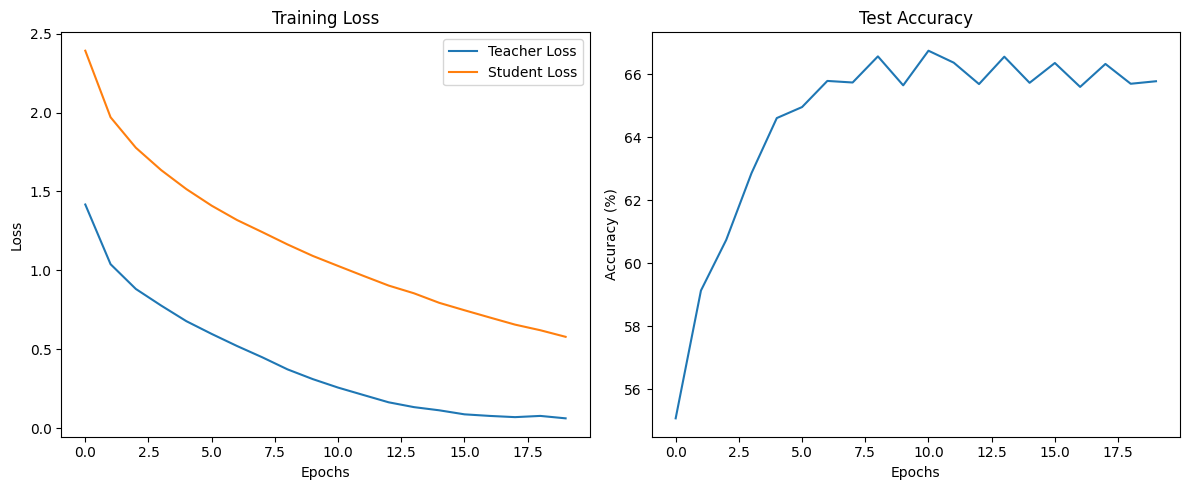

In [ ]:
# Plotting the results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(teacher_train_losses, label="Teacher Loss")
plt.plot(student_train_losses, label="Student Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss")

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label="Student Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Test Accuracy")
plt.tight_layout()
plt.show()


## Testing 2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [ ]:
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:02<00:00, 61427011.88it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
teacher = torchvision.models.resnet34(pretrained=True).cuda() # pretrained
student = torchvision.models.resnet18(pretrained=False).cuda()

In [ ]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(student.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


In [ ]:


train_losses = []
train_accuracies = []
test_accuracies = []
teacher_test_accuracies = []

def test_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return 100 * correct / total

# Training loop
epochs = 10
for epoch in range(epochs):
    student.train()
    teacher.eval()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        student_outputs = student(inputs)
        teacher_outputs = teacher(inputs).detach()

        # KD loss
        loss = criterion(student_outputs, targets) + nn.KLDivLoss()(F.log_softmax(student_outputs, dim=1), F.softmax(teacher_outputs, dim=1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = student_outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_loss = total_loss / (batch_idx + 1)
    train_acc = 100. * correct / total
    test_acc = test_accuracy(student, testloader)
    teacher_test_acc = test_accuracy(teacher, testloader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    teacher_test_accuracies.append(teacher_test_acc)

    print(f"Epoch {epoch+1}/{epochs}.. Train Loss: {train_loss:.4f}.. Train Accuracy: {train_acc:.2f}.. Student Test Accuracy: {test_acc:.2f}.. Teacher Test Accuracy: {teacher_test_acc:.2f}")
    scheduler.step()



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 1/10.. Train Loss: 2.2056.. Train Accuracy: 29.84.. Student Test Accuracy: 37.05.. Teacher Test Accuracy: 0.00
Epoch 2/10.. Train Loss: 1.5261.. Train Accuracy: 44.70.. Student Test Accuracy: 46.45.. Teacher Test Accuracy: 0.00
Epoch 3/10.. Train Loss: 1.3115.. Train Accuracy: 53.40.. Student Test Accuracy: 46.39.. Teacher Test Accuracy: 0.00
Epoch 4/10.. Train Loss: 1.1877.. Train Accuracy: 58.19.. Student Test Accuracy: 58.00.. Teacher Test Accuracy: 0.01
Epoch 5/10.. Train Loss: 1.0847.. Train Accuracy: 62.18.. Student Test Accuracy: 58.23.. Teacher Test Accuracy: 0.00
Epoch 6/10.. Train Loss: 1.0139.. Train Accuracy: 65.01.. Student Test Accuracy: 63.39.. Teacher Test Accuracy: 0.00
Epoch 7/10.. Train Loss: 0.9684.. Train Accuracy: 66.72.. Student Test Accuracy: 62.59.. Teacher Test Accuracy: 0.00
Epoch 8/10.. Train Loss: 0.9290.. Train Accuracy: 68.32.. Student Test Accuracy: 63.78.. Teacher Test Accuracy: 0.00
Epoch 9/10.. Train Loss: 0.8917.. Train Accuracy: 69.39.. Studen

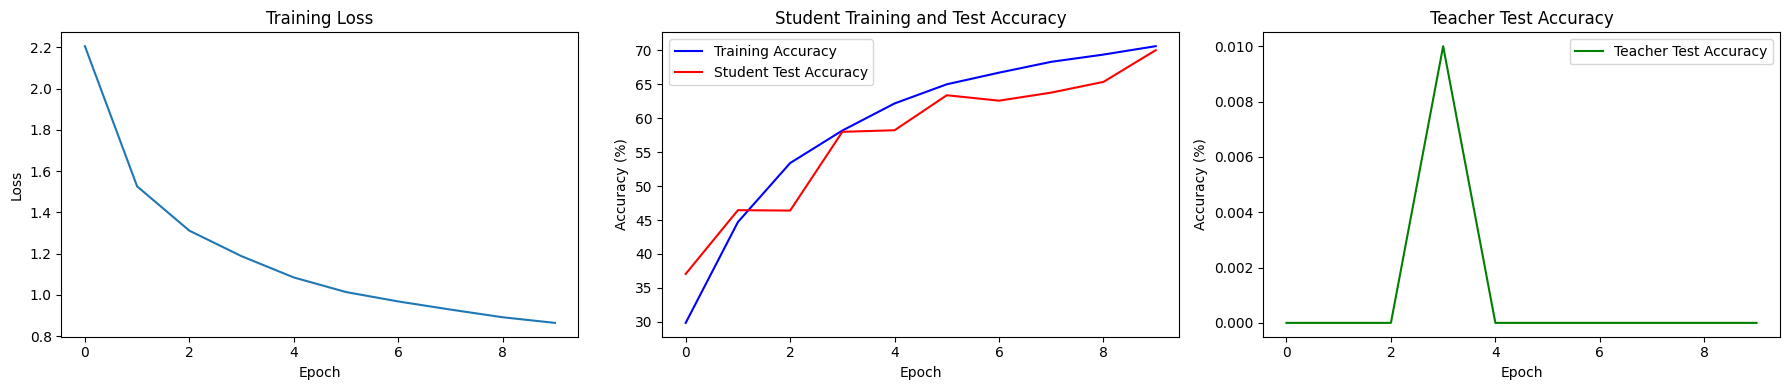

In [ ]:
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(test_accuracies, label='Student Test Accuracy', color='red')
plt.title("Student Training and Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(teacher_test_accuracies, label='Teacher Test Accuracy', color='green')
plt.title("Teacher Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()